In [71]:
import pandas as pd
from apyori import apriori
import matplotlib.pyplot as plt

movies_data = pd.read_csv("movies/movies.csv",  encoding='latin-1')

# Leer datos de un csv
movies_data

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,popularity,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
0,5,4000000,Crime|Comedy,https://www.miramax.com/movie/four-rooms/,Miramax|A Band Apart,US|US,United States of America,4257354.0,98,False,...,20.880,1995-12-09,5.7,2077,2,2,1,25,15,9
1,6,21000000,Action|Thriller|Crime,NaN,Universal Pictures|Largo Entertainment|JVC,US|US|JP,Japan|United States of America,12136938.0,110,False,...,9.596,1993-10-15,6.5,223,3,3,2,15,3,9
2,11,11000000,Adventure|Action|Science Fiction,http://www.starwars.com/films/star-wars-episod...,Lucasfilm|20th Century Fox,US|US,United States of America,775398007.0,121,NaN,...,100.003,1977-05-25,8.2,16598,3,2,1,105,5,62
3,12,94000000,Animation|Family,http://movies.disney.com/finding-nemo,Pixar,US,United States of America,940335536.0,100,NaN,...,134.435,2003-05-30,7.8,15928,2,1,1,24,5,18
4,13,55000000,Comedy|Drama|Romance,NaN,Paramount|The Steve Tisch Company,US|,United States of America,677387716.0,142,False,...,58.751,1994-07-06,8.5,22045,3,2,1,76,18,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,920081,0,Action|Horror,NaN,NaN,NaN,NaN,0.0,100,False,...,16.662,2021-11-26,6.8,108,2,1,1,10,2,4
9996,920143,0,Comedy,NaN,Caracol Televisiï¿½n|Dago Garcï¿½a Producciones,CO|CO,Colombia,0.0,97,False,...,491.706,2021-12-25,1.5,2,1,2,1,8,1,1
9997,922017,0,Comedy,NaN,NaN,NaN,Nigeria,0.0,112,False,...,565.658,2021-12-17,6.1,30,1,1,17,1,0,922017
9998,922162,0,NaN,https://www.netflix.com/title/81425229,NaN,NaN,United States of America,0.0,59,False,...,9.664,2021-12-17,6.0,1,1,0,0,0,922162,The Witcher: Fireplace


# Transformacion de datos

In [72]:
# Budget a datos cualitativos
def categorize_budget(budget):
    if budget < 10_000_000:
        return "Budget Low"
    elif budget < 50_000_000:
        return "Budget Medium"
    elif budget < 150_000_000:
        return "Budget High"
    else:
        return "Budget Very High"

# revenue a datos cualitativos
def categorize_revenue(revenue):
    if revenue < 10_000_000:
        return "Revenue Low"
    elif revenue < 100_000_000:
        return "Revenue Medium"
    elif revenue < 500_000_000:
        return "Revenue High"
    else:
        return "Revenue Very High"

# Runtime a datos cualitativos
def categorize_runtime(runtime):
    if runtime < 90:
        return "Runtime Short"
    elif runtime < 120:
        return "Runtime Medium"
    else:
        return "Runtime Long"

# Avg a datos cualitativos
def categorize_vote_avg(vote_avg):
    if vote_avg < 5:
        return "Avg Vote Poor"
    elif vote_avg < 7:
        return "Avg Vote Average"
    elif vote_avg < 8.5:
        return "Avg Vote Good"
    else:
        return "Avg Vote Excellent"

# vote count a datos cualitativos
def categorize_vote_count(vote_count):
    if vote_count < 1000:
        return "Vote Count Low"
    elif vote_count < 10000:
        return "Vote Count Medium"
    else:
        return "Vote Count High"

# popularity a datos cualitativos
def categorize_popularity(popularity):
    if popularity < 10:
        return "Popularity Low"
    elif popularity < 50:
        return "Popularity Medium"
    elif popularity < 100:
        return "Popularity High"
    else:
        return "Popularity Very High"

df_transformed = movies_data.copy()
df_transformed["budget"] = movies_data["budget"].apply(pd.to_numeric, errors="coerce").apply(categorize_budget)
df_transformed["revenue"] = movies_data["revenue"].apply(pd.to_numeric, errors="coerce").apply(categorize_revenue)
df_transformed["runtime"] = movies_data["runtime"].apply(pd.to_numeric, errors="coerce").apply(categorize_runtime)
df_transformed["voteAvg"] = movies_data["voteAvg"].apply(pd.to_numeric, errors="coerce").apply(categorize_vote_avg)
df_transformed["voteCount"] = movies_data["voteCount"].apply(pd.to_numeric, errors="coerce").apply(categorize_vote_count)
df_transformed["popularity"] = movies_data["popularity"].apply(pd.to_numeric, errors="coerce").apply(categorize_popularity)

movies_transformed = df_transformed[["budget", "revenue", "runtime", "voteAvg", "voteCount", "popularity"]]

movies_transformed

,budget,revenue,runtime,voteAvg,voteCount,popularity
0,Budget Low,Revenue Low,Runtime Medium,Avg Vote Average,Vote Count Medium,Popularity Medium
1,Budget Medium,Revenue Medium,Runtime Medium,Avg Vote Average,Vote Count Low,Popularity Low
2,Budget Medium,Revenue Very High,Runtime Long,Avg Vote Good,Vote Count High,Popularity Very High
3,Budget High,Revenue Very High,Runtime Medium,Avg Vote Good,Vote Count High,Popularity Very High
4,Budget High,Revenue Very High,Runtime Long,Avg Vote Excellent,Vote Count High,Popularity High
...,...,...,...,...,...,...
9995,Budget Low,Revenue Low,Runtime Medium,Avg Vote Average,Vote Count Low,Popularity Medium
9996,Budget Low,Revenue Low,Runtime Medium,Avg Vote Poor,Vote Count Low,Popularity Very High
9997,Budget Low,Revenue Low,Runtime Medium,Avg Vote Average,Vote Count Low,Popularity Very High
9998,Budget Low,Revenue Low,Runtime Short,Avg Vote Average,Vote Count Low,Popularity Low


In [ ]:
print(movies_transformed.shape)

records = []

for i in range(0, 10000):
    records.append([str(movies_transformed.values[i,j]) for j in range(0, 6)]) 
records


(10000, 6)


[['Budget Low',
  'Revenue Low',
  'Runtime Medium',
  'Avg Vote Average',
  'Vote Count Medium',
  'Popularity Medium'],
 ['Budget Medium',
  'Revenue Medium',
  'Runtime Medium',
  'Avg Vote Average',
  'Vote Count Low',
  'Popularity Low'],
 ['Budget Medium',
  'Revenue Very High',
  'Runtime Long',
  'Avg Vote Good',
  'Vote Count High',
  'Popularity Very High'],
 ['Budget High',
  'Revenue Very High',
  'Runtime Medium',
  'Avg Vote Good',
  'Vote Count High',
  'Popularity Very High'],
 ['Budget High',
  'Revenue Very High',
  'Runtime Long',
  'Avg Vote Excellent',
  'Vote Count High',
  'Popularity High'],
 ['Budget Medium',
  'Revenue High',
  'Runtime Long',
  'Avg Vote Good',
  'Vote Count Medium',
  'Popularity Medium'],
 ['Budget Low',
  'Revenue Medium',
  'Runtime Medium',
  'Avg Vote Good',
  'Vote Count Medium',
  'Popularity Medium'],
 ['Budget Medium',
  'Revenue Medium',
  'Runtime Long',
  'Avg Vote Good',
  'Vote Count Medium',
  'Popularity Medium'],
 ['Budget H

# Apriori

In [110]:
reglas_asociacion = apriori(records, min_support=0.35, min_confidence = 0.65)
reglas = list(reglas_asociacion)
print(len(reglas))
list(reglas)

19


[RelationRecord(items=frozenset({'Popularity Medium'}), support=0.7558, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Popularity Medium'}), confidence=0.7558, lift=1.0)]),
 RelationRecord(items=frozenset({'Vote Count Low'}), support=0.6902, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Vote Count Low'}), confidence=0.6902, lift=1.0)]),
 RelationRecord(items=frozenset({'Popularity Medium', 'Avg Vote Average'}), support=0.4668, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Avg Vote Average'}), items_add=frozenset({'Popularity Medium'}), confidence=0.7677631578947368, lift=1.015828470355566)]),
 RelationRecord(items=frozenset({'Runtime Medium', 'Avg Vote Average'}), support=0.3912, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Runtime Medium'}), items_add=frozenset({'Avg Vote Average'}), confidence=0.6706668952511572, lift=1.1030705513999297)]),
 RelationRecord(items=frozenset({'Avg Vote 

## Se crearon 19 reglas de asociacion

In [111]:
output = list(reglas)

def inspect(output):
    lhs = []
    rhs = []
    support = []
    confidence = []
    lift = []
    
    for rule in output:
        for ordered_stat in rule.ordered_statistics:
            lhs_value = ', '.join(map(str, ordered_stat.items_base)) if ordered_stat.items_base else ', '.join(map(str, ordered_stat.items_add))
            rhs_value = ', '.join(map(str, ordered_stat.items_add)) if ordered_stat.items_add else ', '.join(map(str, ordered_stat.items_base))

            lhs.append(lhs_value if lhs_value else "Unknown")
            rhs.append(rhs_value if rhs_value else "Unknown")
            support.append(rule.support)  
            confidence.append(ordered_stat.confidence)  
            lift.append(ordered_stat.lift)  

    return list(zip(lhs, rhs, support, confidence, lift))

output_DataFrame = pd.DataFrame(inspect(output), columns=['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,Popularity Medium,Popularity Medium,0.7558,0.755800,1.000000
1,Vote Count Low,Vote Count Low,0.6902,0.690200,1.000000
2,Avg Vote Average,Popularity Medium,0.4668,0.767763,1.015828
3,Runtime Medium,Avg Vote Average,0.3912,0.670667,1.103071
4,Avg Vote Average,Vote Count Low,0.4333,0.712664,1.032548
5,Budget Low,Popularity Medium,0.4990,0.785703,1.039565
6,Popularity Medium,Budget Low,0.4990,0.660228,1.039565
7,Budget Low,Revenue Low,0.5494,0.865061,1.415579
8,Revenue Low,Budget Low,0.5494,0.899035,1.415579
9,Budget Low,Vote Count Low,0.5582,0.878917,1.273423


# Conclusiones

#### Las películas con presupuesto bajo generalmente tienen ingresos bajos y esto se confirma en múltiples reglas con alta confianza y soporte.
#### La cantidad de votos es un fuerte predictor del éxito financiero: Las películas con pocos votos tienen más probabilidades de generar menos ingresos.
#### Las películas más populares pueden generar ingresos bajos si su presupuesto es bajo, lo que sugiere que la popularidad por sí sola no garantiza altos ingresos.
#### Las películas más cortas suelen recibir menos votos, lo que podría indicar una menor percepción de calidad o menor engagement del público.

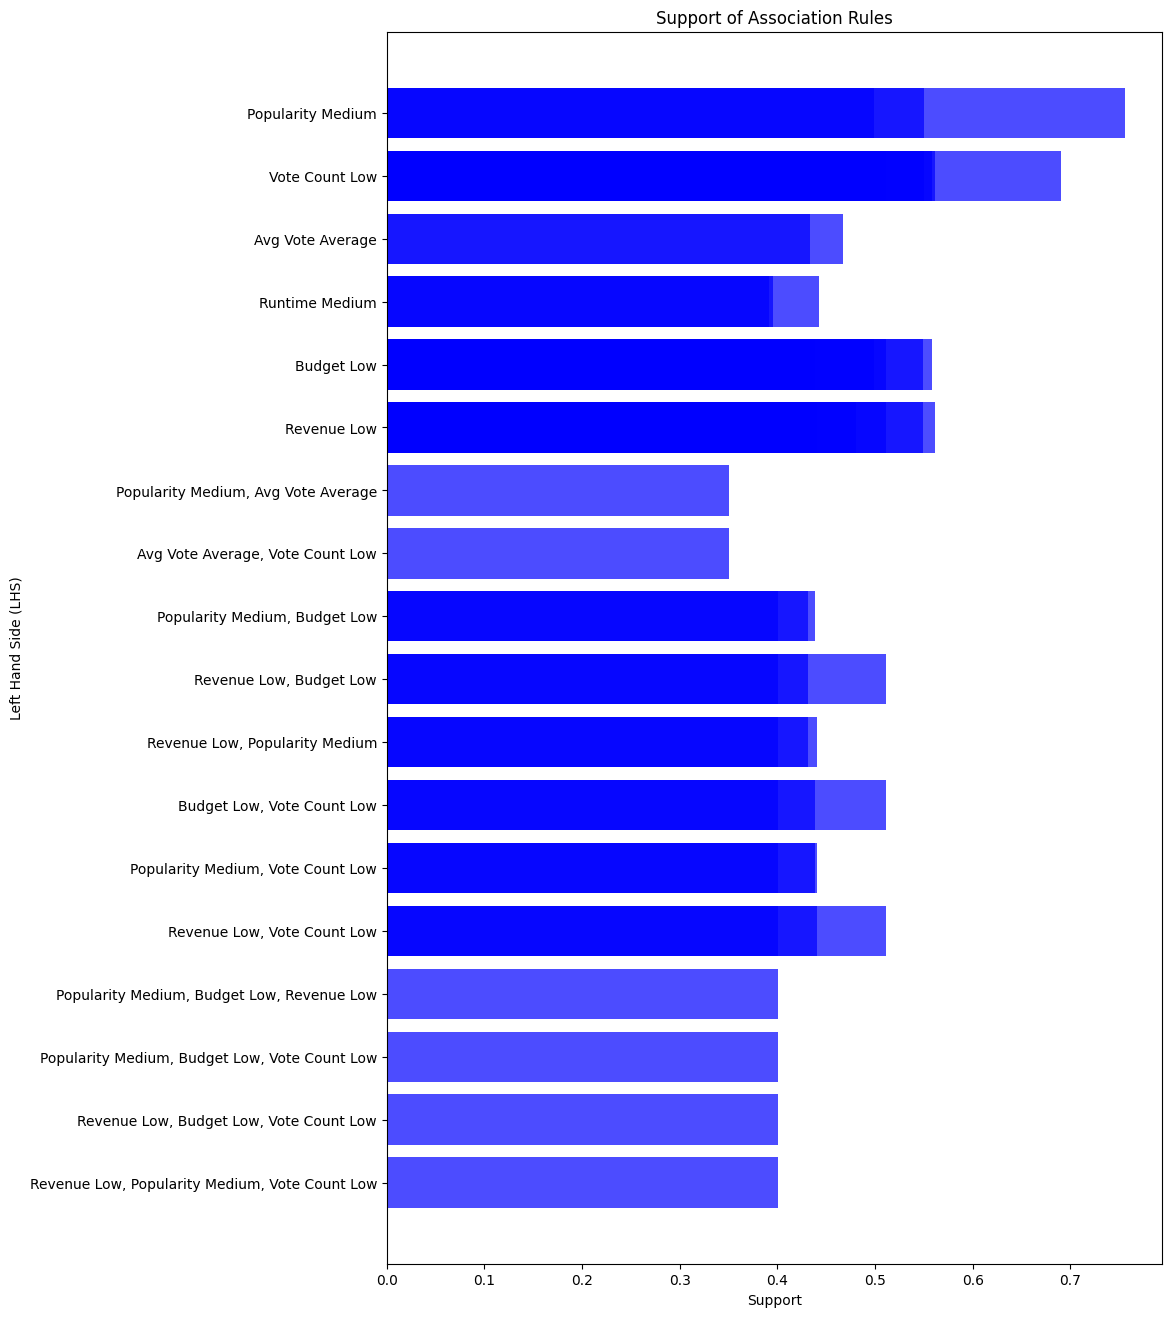

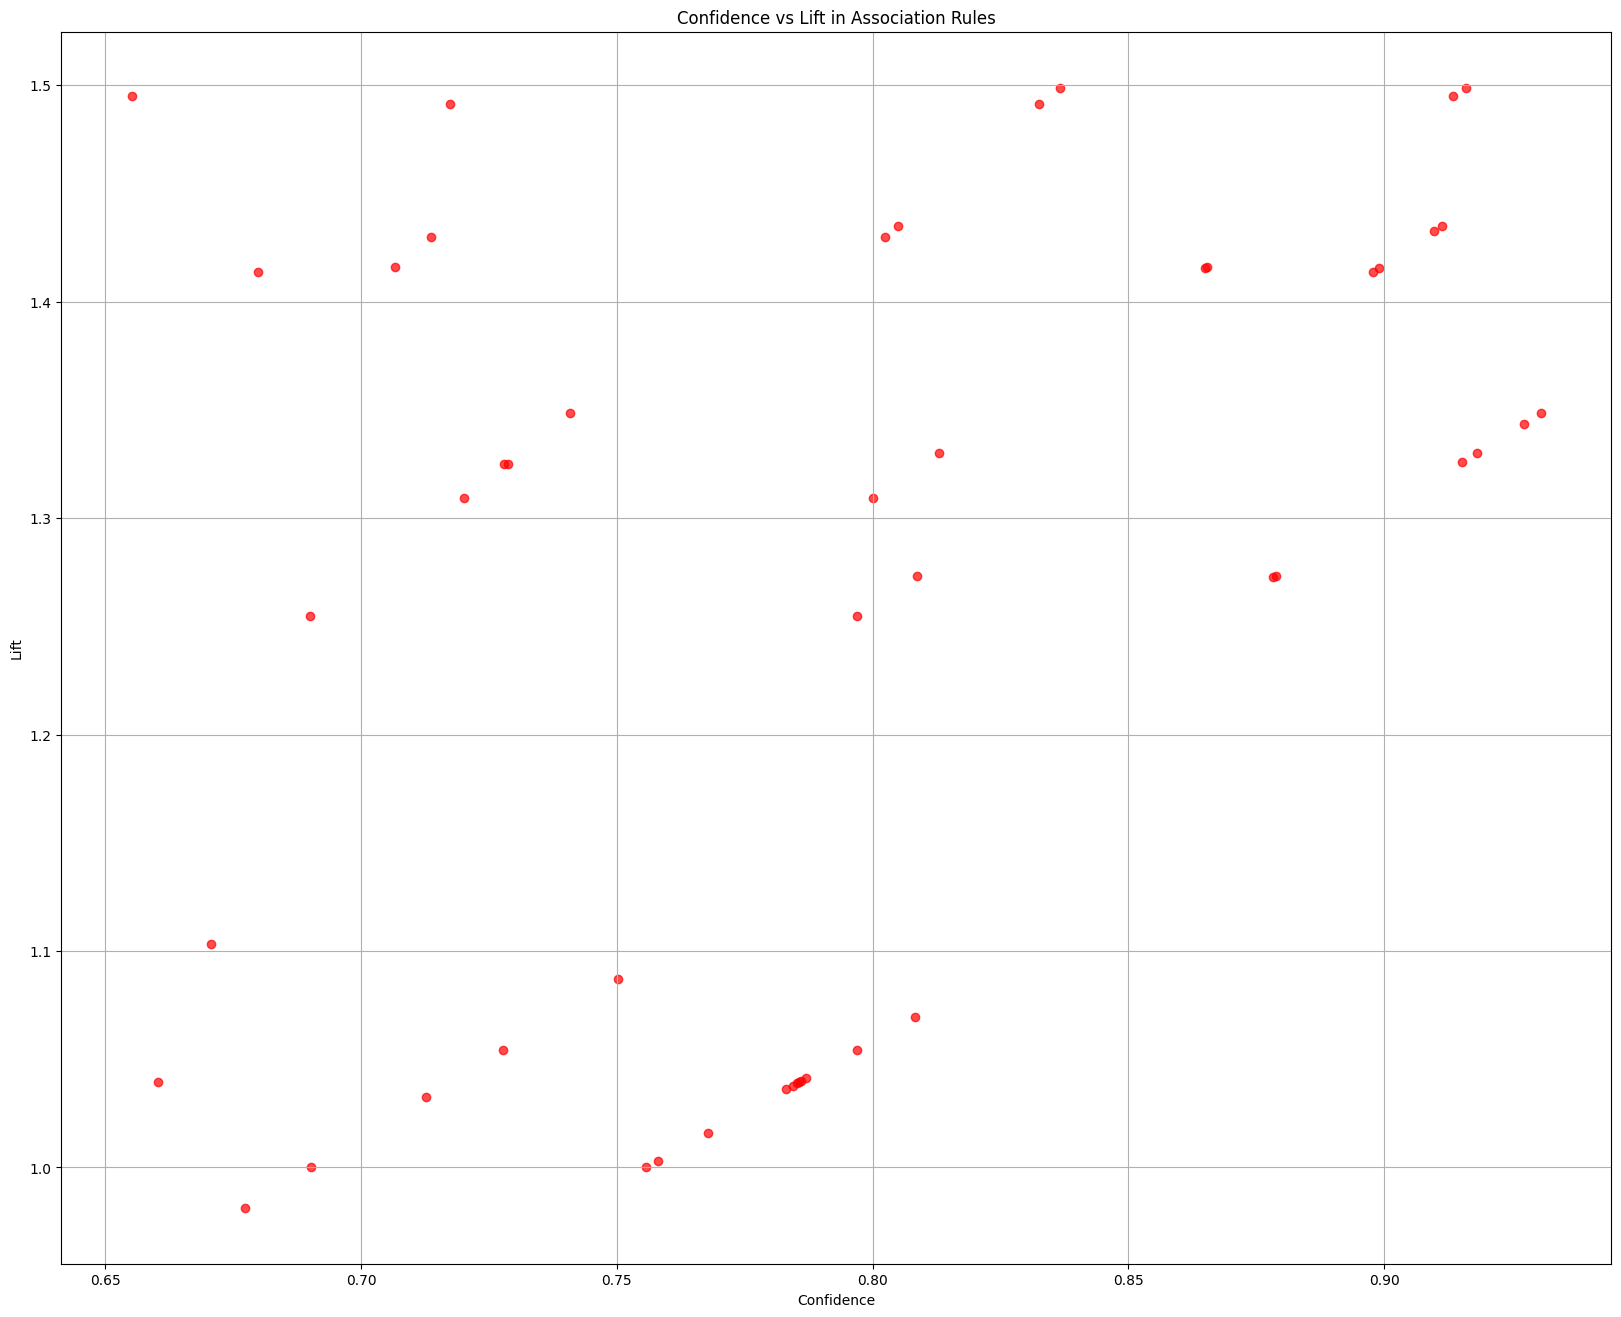

In [112]:
# Crear un gráfico de barras para el soporte de las reglas
plt.figure(figsize=(10, 16))
plt.barh(output_DataFrame["Left_Hand_Side"], output_DataFrame["Support"], color="blue", alpha=0.7)
plt.xlabel("Support")
plt.ylabel("Left Hand Side (LHS)")
plt.title("Support of Association Rules")
plt.gca().invert_yaxis()
plt.show()

# Crear un scatter plot para confianza vs lift
plt.figure(figsize=(20, 16))
plt.scatter(output_DataFrame["Confidence"], output_DataFrame["Lift"], c="red", alpha=0.7)
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.title("Confidence vs Lift in Association Rules")
plt.grid(True)
plt.show()
